
# Анализ тональности — Логистическая регрессия + визуализация


In [ ]:

import os, csv, re, random, string, numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from typing import List, Dict, Tuple

In [ ]:
import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')
# nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/oli/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/oli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


## 1. Данные: CSV или демо-набор

In [ ]:

def load_or_demo_ru_dataset(path='/data/ru_sentiment.csv'):
    texts, labels = [], []
    if os.path.exists(path):
        with open(path, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            assert 'text' in reader.fieldnames and 'label' in reader.fieldnames, "Нужны колонки text,label"
            for row in reader:
                texts.append(row['text'])
                labels.append(int(row['label']))
        print(f"Загружен датасет: {len(texts)} строк из {path}")
    else:
        pos = [
            "Фильм отличный, получила огромное удовольствие!",
            "Очень понравился сервис, всё быстро и качественно.",
            "Музыка вдохновляет, прекрасное исполнение.",
            "Хороший товар, соответствует описанию.",
            "Книга захватывает, рекомендую!",
            "Прекрасное приложение, удобно и функционально.",
            "Ресторан порадовал вкусной кухней и атмосферой.",
            "Поддержка ответила быстро, проблему решили.",
            "Курс полезный и понятный, много практики.",
            "Отличная работа команды!"
        ]
        neg = [
            "Фильм скучный и затянутый, жаль времени.",
            "Сервис ужасный, не отвечают на сообщения.",
            "Музыка отвратительная, трудно слушать.",
            "Товар пришёл повреждённый, разочарована.",
            "Книга не понравилась, слабый сюжет.",
            "Приложение вылетает и тормозит.",
            "Еда невкусная, обслуживание медленное.",
            "Поддержка молчит, проблему не решили.",
            "Курс пустой, ничего нового.",
            "Команда подвела, сроки сорваны."
        ]
        texts = pos + neg
        labels = [1]*len(pos) + [0]*len(neg)
        print(f"Используется демо-набор: {len(texts)} примеров")
    return texts, np.array(labels, dtype=int)

texts, labels = load_or_demo_ru_dataset()


Используется демо-набор: 20 примеров


## 2. Предобработка и подсчет частот

In [ ]:

ru_stop = set(stopwords.words('russian'))
stemmer = SnowballStemmer("russian")
token_re = re.compile(r"[A-Za-zА-Яа-яЁё]+")

In [ ]:
ru_stop

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [ ]:
# функция process_ru
# разбивает входящий текст на слова,
# удаляет стоп слова,
# возвращает список слов
# например,
# text = "Целый день он бился, метался в клетке и ревел, потом лёг подле мёртвой собачки и затих"
# process_ru(text)
# ['цел',  'ден', 'бил', 'мета', 'клетк',  'ревел', 'лег', 'подл', 'мертв', 'собачк', 'зат']

def process_ru(text: str):
    .....

text = "Целый день он бился, метался в клетке и ревел, потом лёг подле мёртвой собачки и затих"
process_ru(text)

['цел',
 'ден',
 'бил',
 'мета',
 'клетк',
 'ревел',
 'лег',
 'подл',
 'мертв',
 'собачк',
 'зат']

In [ ]:

from collections import defaultdict

# построить частотный словарь для каждого класса
# для каждого слова будет возвращена информация в каком классе и сколько раз оно встречается
# {('фильм', 1): 1, ('отличн', 1): 2, ('получ', 1): 1,....  ('фильм', 0): 1, ('скучн', 0): 1, ('затянут', 0): 1, ....}

def build_freqs_ru(texts, ys):
    ....

freqs = build_freqs_ru(texts, labels)


In [ ]:
freqs

defaultdict(int,
            {('фильм', 1): 1,
             ('отличн', 1): 2,
             ('получ', 1): 1,
             ('огромн', 1): 1,
             ('удовольств', 1): 1,
             ('очен', 1): 1,
             ('понрав', 1): 1,
             ('сервис', 1): 1,
             ('все', 1): 1,
             ('быстр', 1): 2,
             ('качествен', 1): 1,
             ('музык', 1): 1,
             ('вдохновля', 1): 1,
             ('прекрасн', 1): 2,
             ('исполнен', 1): 1,
             ('хорош', 1): 1,
             ('товар', 1): 1,
             ('соответств', 1): 1,
             ('описан', 1): 1,
             ('книг', 1): 1,
             ('захватыва', 1): 1,
             ('рекоменд', 1): 1,
             ('приложен', 1): 1,
             ('удобн', 1): 1,
             ('функциональн', 1): 1,
             ('рестора', 1): 1,
             ('порадова', 1): 1,
             ('вкусн', 1): 1,
             ('кухн', 1): 1,
             ('атмосфер', 1): 1,
             ('поддержк', 1): 1,
 

## 3. Логистическая регрессия «с нуля» + график сходимости

In [ ]:

import numpy as np

# превращает текст в очень простой вектор признаков из 3 чисел:
# [bias=1, сумма_позитивных_частот, сумма_негативных_частот].
# bias=1 нужен линейным моделям как свободный коэффициент.
# Так мы кодируем текст в очень компактные признаки, где модель “видит”,
# насколько слова из текста чаще встречались у позитивных vs. негативных примеров.
# Далее этот вектор подаётся в логистическую регрессию «с нуля»  для предсказания тональности.

# Ограничение: грубый признак — игнорирует порядок слов, отрицания (“не понравилось”),
# и различия силы отдельного слова (все слова просто суммируются).
# Для лучшего качества обычно используют TF-IDF или другие способы
# например, для следующих фраз соответствующие вектора выглядят так
# "Фильм отличный, получила огромное удовольствие!"
# [1. 6. 1.]
# "Очень понравился сервис, всё быстро и качественно."
# [1. 7. 2.]

def extract_features_ru(text: str, freqs) -> np.ndarray:
    ....

In [ ]:

X = np.zeros((len(texts), 3))
for i, t in enumerate(texts):
    X[i, :] = extract_features_ru(t, freqs)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=labels)

In [ ]:
# запишите уравнение сигмоиды
def sigmoid(z):
    return ....

In [ ]:
def gradient_descent(X, y, theta, alpha=1e-2, iters=800):
    # X: (m, n) — матрица признаков (m примеров, n признаков)
    # y: (m,) или (m,1) — бинарные метки {0,1}
    # theta: (n,1) — вектор весов (включая bias, если первый столбец X — единицы)
    # alpha — шаг обучения (learning rate)
    # iters — число итераций

    m = len(X)                          # m — число объектов (документов/примеров)
    y = y.reshape(-1, 1).astype(float)  # приводим y к форме (m,1) и типу float для матр. операций
    J_hist = []                         # сюда будем писать историю значения функции стоимости

    for i in range(iters):
        # Прямой проход: линейная комбинация признаков и сигмоида
        # z = X @ theta имеет форму (m,1)
        # h = sigma(z) — предсказанные вероятности класса "1" для всех m объектов
        h = sigmoid(X @ theta)          # h: (m,1) в диапазоне (0,1)

        # Функция стоимости (логистическая регрессия, бинарная кросс-энтропия):
        # J(θ) = -(1/m) * [ y^T log(h) + (1-y)^T log(1-h) ]
        # Добавляем маленький epsilon (1e-12), чтобы избежать log(0)
        # J(θ) = -(1/m) * [ y^T log(h+ 1e-12) + (1-y)^T log(1-h+ 1e-12) ]
        #
        J =  -(1/m) * (y.T @ np.log(h+ 1e-12) + (1-y).T @ np.log(1-h+ 1e-12) )                              # J — скаляр (матрица 1x1)

        # Градиент J по theta:
        # grad = (1/m) * X^T (h - y)   форма (n,1)
        grad = (1/m) * (X.T @ (h - y))

        # Шаг градиентного спуска — двигаемся ПРОТИВ градиента
        #
        theta -= alpha*grad

        # Сохраняем стоимость примерно 10 раз за обучение (чтобы рисовать график сходимости)
        if i % max(1, iters // 10) == 0:
            J_hist.append(float(J))

    # Возвращаем последнюю стоимость (как float), обученные веса и историю J
    return float(J), theta, J_hist


/tmp/ipykernel_263572/3987083808.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J_hist.append(float(J))
/tmp/ipykernel_263572/3987083808.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(J), theta, J_hist


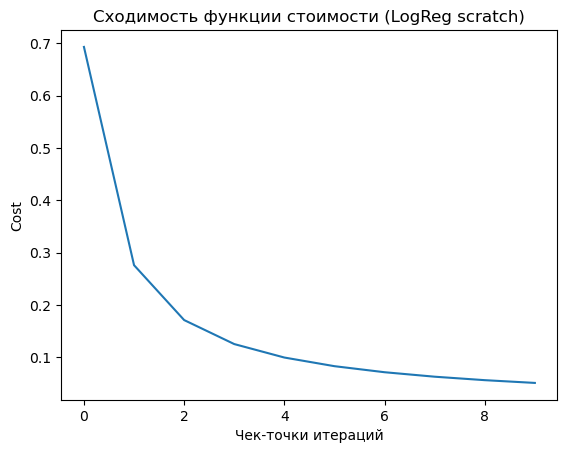

In [ ]:

theta0 = np.zeros((X_train.shape[1], 1))
final_cost, theta, J_hist = gradient_descent(X_train, y_train, theta0, alpha=1e-2, iters=800)

plt.figure()
plt.title("Сходимость функции стоимости (LogReg scratch)")
plt.plot(J_hist)
plt.xlabel("Чек-точки итераций")
plt.ylabel("Cost")
plt.show()


## 4. Оценка + матрица ошибок

Accuracy: 1.0 | Precision: 1.0 Recall: 1.0 F1: 1.0


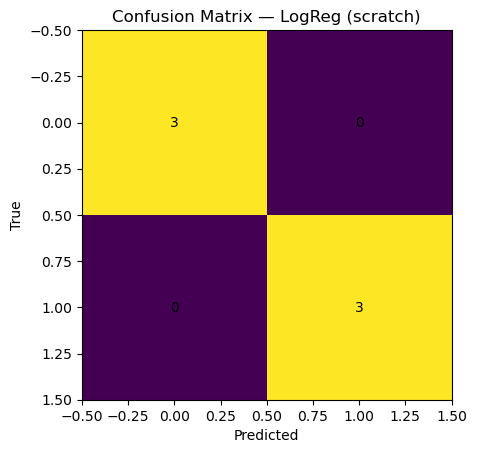

In [ ]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

y_hat = (sigmoid(X_test @ theta).reshape(-1) > 0.5).astype(int)
acc = accuracy_score(y_test, y_hat)
p, r, f1, _ = precision_recall_fscore_support(y_test, y_hat, average='binary', zero_division=0)
print("Accuracy:", acc, "| Precision:", round(p,3), "Recall:", round(r,3), "F1:", round(f1,3))

cm = confusion_matrix(y_test, y_hat)
plt.figure()
plt.title("Confusion Matrix — LogReg (scratch)")
plt.imshow(cm)
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()


## 6. TF-IDF + MultinomialNB; TF-IDF + LogisticRegression

In [ ]:

X_tr, X_te, y_tr, y_te = train_test_split(texts, labels, test_size=0.3, random_state=42, stratify=labels)

pipe_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(ru_stop), max_features=20000, ngram_range=(1,2))),
                    ('clf', MultinomialNB())])

pipe_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(ru_stop), max_features=20000, ngram_range=(1,2))),
                    ('clf', LogisticRegression(max_iter=300))])

for name, pipe in [('MultinomialNB', pipe_nb), ('LogisticRegression', pipe_lr)]:
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_te, preds))
    print(classification_report(y_te, preds, target_names=['neg','pos']))


=== MultinomialNB ===
Accuracy: 0.16666666666666666
              precision    recall  f1-score   support

         neg       0.25      0.33      0.29         3
         pos       0.00      0.00      0.00         3

    accuracy                           0.17         6
   macro avg       0.12      0.17      0.14         6
weighted avg       0.12      0.17      0.14         6

=== LogisticRegression ===
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

         neg       0.33      0.33      0.33         3
         pos       0.33      0.33      0.33         3

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6



## 7. Частоты и WordCloud (тег-облако)

In [ ]:

def class_word_counts(texts, labels):
    pos_words, neg_words = [], []
    for t, y in zip(texts, labels):
        ws = process_ru(t)
        if y == 1: pos_words.extend(ws)
        else: neg_words.extend(ws)
    return Counter(pos_words), Counter(neg_words)

pos_cnt, neg_cnt = class_word_counts(texts, labels)

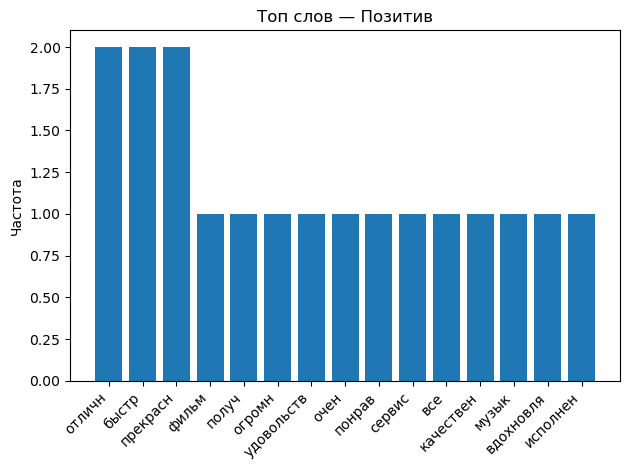

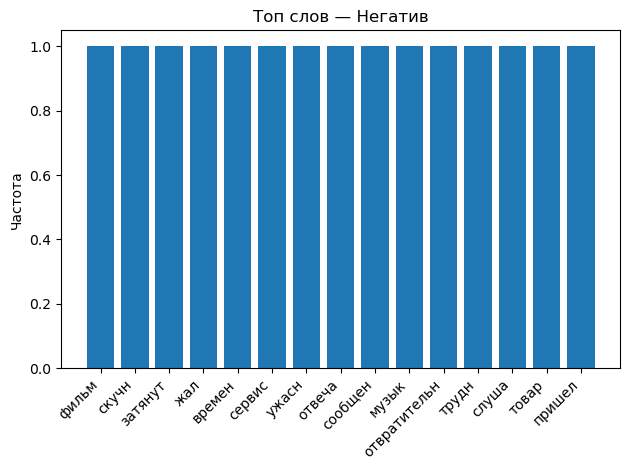

In [ ]:

def plot_top_words(cnt, title, k=15):
    top = cnt.most_common(k)
    words, freqs = zip(*top) if top else ([], [])
    plt.figure()
    plt.title(title)
    plt.bar(range(len(words)), freqs)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.ylabel("Частота"); plt.tight_layout(); plt.show()

plot_top_words(pos_cnt, "Топ слов — Позитив", 15)
plot_top_words(neg_cnt, "Топ слов — Негатив", 15)

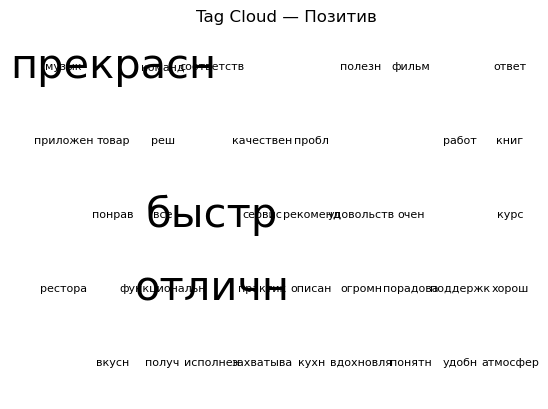

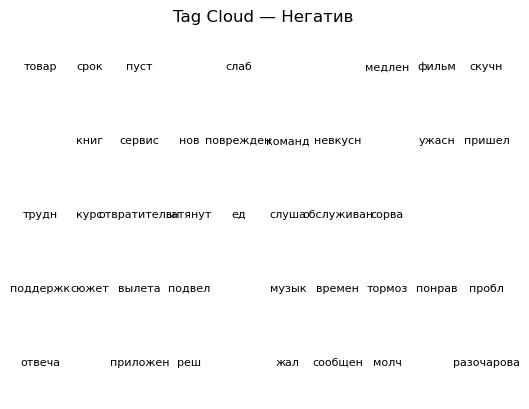

In [ ]:

def plot_tag_cloud(counter, title, max_words=50):
    top = counter.most_common(max_words)
    if not top:
        print("Недостаточно данных для облака")
        return
    words, freqs = zip(*top)
    freqs = np.array(freqs, dtype=float)
    sizes = 8 + 22 * (freqs - freqs.min()) / (freqs.max() - freqs.min() + 1e-9)
    import random
    grid_w, grid_h = 10, 5
    coords = [(x, y) for y in range(grid_h) for x in range(grid_w)]
    random.shuffle(coords)
    plt.figure(); plt.title(title); plt.axis('off')
    for (w, s), (gx, gy) in zip(zip(words, sizes), coords[:len(words)]):
        x = (gx + 0.5) / grid_w; y = 1 - (gy + 0.5) / grid_h
        plt.text(x, y, w, fontsize=float(s), ha='center', va='center')
    plt.show()

plot_tag_cloud(pos_cnt, "Tag Cloud — Позитив", max_words=40)
plot_tag_cloud(neg_cnt, "Tag Cloud — Негатив", max_words=40)
